# <center> PoC: Rossman Store Sales Forecast Machine Learning Models</center>
    
<center>By Jingjing Guo </center>

 <center>Aug 10 2019 </center>
 
<p>
The notebook documents the codes used to develop machine learning models for Rossman store sales forecast. </p>

__Dataset:__
- *train.csv*: contains daily sales history given Date, store, promotion, and holiday for Jan 1 2013 to Jul 31 2015
- *test.csv*: same as _train.csv_, except for sales and cutomers, for Aug 1 2015 to Sep 17 2015 (about 6 weeks)
- *store.csv*: additional information on store type, assortment/inventory, competition and promotion for each store.

__Desired outputs__:
- 1) _Best machine learning model that can forecast performances_ e.g. least expected Root Mean Squared Error (RMS) in candidate models
- 2) _Forecast sales 6 weeks_ into the future from the last day in the train data

__Outline__: The code and comments below documents five major steps taken to arrive at the final model:
- Data Validation
- Data Cleaning/Feature Extraction
- Model Comparison
- Final Model Training
- Report test results

# 1. Libaries and Load Data

In [1]:
# Libraries
import pandas as pd
import numpy as np
import statistics as sts
import datetime
from time import strptime

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 10.0)

In [2]:
# Load Data
ds = pd.read_csv('data/store.csv', index_col=0) # store
dt = pd.read_csv('data/train.csv', parse_dates=[2], dtype={'StateHoliday': np.dtype(str)}) # train
dp = pd.read_csv('data/test.csv', parse_dates=[3], index_col=0, dtype={'StateHoliday': np.dtype(str)}) # test/prediction


# 2. Data Validation

From cross examine all available data, the following data consisentency are to be validated:
- **Competition**: multiple columns, CompetitionOpenSinceYear and CompetitionOpenWeek must be simultanenously null
- **Holidays**: N/A
- **Promotion**: multiple columns,Promo2 related items must be null when Promo2 is 0
- **Sales History**: Redundant information: store close => no sales, Date => DayOfWeek
- **Store type/assortments**: check if related

In [3]:
# Are competition Date related columns consistent?
cols = [s for s in ds.columns if 'CompetitionOpen' in s]
test = ds[cols]
cols
assert all(test[cols[0]].isnull()==test[cols[1]].isnull()),\
'CompetitionOpenSinceYear and CompetitionOpenWeek are NOT simultanenously null.'

In [4]:
# Are Promo2 related columns consistent?
cols = [s for s in ds.columns if 'Promo' in s]
test = ds[cols]
cols
assert all(test[test.Promo2==0].drop('Promo2',1).isnull()),\
'Promo2 related items are NOT null when Promo2 is 0'

In [5]:
# Are Open and Sales/Customer number consistent? 
assert all(dt[dt.Open==0].Sales == 0)
assert all(dt[dt.Open==0].Customers == 0),\
'Sales/customers are 0 when store is closed'

In [6]:
# Are day of week consistent with dates?
test = dt[['Date', 'DayOfWeek']]
assert all(test.Date.dt.dayofweek == test.DayOfWeek-1), \
'DayOfWeek is NOT consistent with Date'

In [7]:
# Do stores have the all dates?
test = dt.groupby('Store').Date.apply(lambda x: x.shape[0])
res = test.value_counts()
for i in range(res.shape[0]):
    print(res.iloc[i],'stores has', res.index[i], 'daily sales')

934 stores has 942 daily sales
180 stores has 758 daily sales
1 stores has 941 daily sales


In [8]:
# Are store types and assortments related?
# ds.groupby('StoreType')['Assortment'].apply(lambda x: x.value_counts())
ds.groupby('Assortment')['StoreType'].apply(lambda x: x.value_counts().sort_index())

Assortment   
a           a    381
            b      7
            c     77
            d    128
b           b      9
c           a    221
            b      1
            c     71
            d    220
Name: StoreType, dtype: int64

### Data Validation Comments:

From the above tests, it can be concluded the data are generally consistent. 
- Competition, promotion, sales, and dates are consistent across related and redundant columns. 
- The store type and assortment are not directly correlated, and should be treated as two different inputs.

# 3. Feature Extraction/Engineering

### Step 1: Add sales history to store data as possible new features

In [9]:
def enrich_store_data(d_stores, d_train):
    """This function adds additional information to store data from sales history in train data.
    Inputs: store.csv, train.csv
    Output: store data with'PromoInterval'converted to numerical month lists, and additional columns:
            'CompetitionOpenDate'
            'Promo2StartDate'
            'SalesPerCustomerMean'
            'SalesPerCustomerVar'
            'SalesMean'
            'SalesVar'
            'CustomerMean'
            'CustomerVar'
    Note the '*Var' are standard deviations to keep values on the same scale.
    """
    
    d_stores = d_stores.fillna(-1)
    
    # Get start dates of competition and Promotion 2, used LATER to find
    #    - How many days since competition open
    #    - How many days since promo 2 started
    #    - Whether Promo2 is ongoing, per promo interval   
    for i in range(6):
        d_stores.iloc[:,i+2] = d_stores.iloc[:,i+2].astype(int)
    d_stores['CompetitionOpenDate'] = d_stores\
                                        .apply(lambda x: datetime.datetime.strptime(
                                            str(x.CompetitionOpenSinceYear) + str(x.CompetitionOpenSinceMonth)+'-1', "%Y%m-%d")
                                            if (x.CompetitionOpenSinceYear>0) else -1, axis=1
                                              )
    d_stores['Promo2StartDate'] = d_stores\
                                    .apply(lambda x: datetime.datetime.strptime(
                                            str(x.Promo2SinceYear) + str(x.Promo2SinceWeek)+'-1', "%Y%W-%d")
                                            if (x.Promo2SinceWeek>0) else -1, axis=1
                                              )
    d_stores['PromoInterval'] = d_stores.apply((lambda x: [strptime(m[:3],'%b').tm_mon for m in x.PromoInterval.split(',')] if x.Promo2>0 else [] ), axis=1)

    # Get Store specific statistics for the historical set, on days that are open:
    #    - Daily sales mean
    #    - Daily sales standard deviation
    #    - Daily customers mean
    #    - Daily customers standard deviation
    #    - Daily sales per customer mean
    #    - Daily sales per customer standard deviation
    dto = d_train[d_train.Open==1]
    dto['StoreSalesPerCustomerMean'] = dto.apply(lambda x: x.Sales/x.Customers if x.Customers>0 else 0, axis=1)
    d_stores['SalesPerCustomerMean']=dto.groupby('Store').StoreSalesPerCustomerMean.mean()
    d_stores['SalesPerCustomerVar']=dto.groupby('Store').StoreSalesPerCustomerMean.apply(lambda x: sts.stdev(x))
    d_stores['SalesMean'] = dto.groupby('Store').Sales.mean()
    d_stores['SalesVar'] = dto.groupby('Store').Sales.apply(lambda x: sts.stdev(x))
    d_stores['CustomerMean'] = dto.groupby('Store').Customers.mean()
    d_stores['CustomerVar'] = dto.groupby('Store').Customers.apply(lambda x: sts.stdev(x))
    
    return d_stores.replace(-1,np.nan)

# test:
# ds1 = enrich_store_data(ds,dt[:100000])

### Step 2: Combine store data and sales history to a set of starting features

In [10]:
def get_features(d_stores, d_train):
    """This function combines information in ENRICHED store data and the raw train data into a single feature table with only OPEN sales.
    Inputs: enriched store data, original train data
    Output: new train data with all STARTING features and target column:
            'Store', 
            'StoreType',
            'Customers',
            'SalesPerCustomer',
            'SalesPerCustomerMean',
            'SalesPerCustomerVar',
            'SalesMean',
            'SalesVar',
            'CustomerMean',
            'CustomerVar',
            'Assortment',
            'CompetitionDistance',
            'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear',
            'CompetitionLength',
            'Promo',
            'Promo2',
            'Promo2SinceWeek',
            'Promo2SinceYear',
            'PromoInterval',
            'Promo2Length',
            'Year',
            'Month',
            'Day',
            'DayOfWeek',
            'StateHoliday',
            'SchoolHoliday',
            'Sales'
    """
    d_train = d_train[d_train.Open==1]
    # populate stores as new variables:
    df = pd.merge(d_train, d_stores, how='left', left_on='Store', right_index=True)

    # get Year, Month, and Day for seasonality
    df['Year'] = df.apply(lambda x: x.Date.year, axis=1)
    df['Month'] = df.apply(lambda x: x.Date.month, axis=1)
    df['Day'] = df.apply(lambda x: x.Date.day, axis=1)
    
    # Get How long has competition existed?
    # Date - CompetitionStartDate
    df['CompetitionLength'] = df.apply(lambda x: (x.Date - x.CompetitionOpenDate).days if pd.notnull(x.CompetitionOpenDate) else np.nan, axis=1)
    # Check if Promo2 is ongoing
    # Cond1: Date > Promo2StartDate; Cond2: Date in Promo2 Interval Months
    df.Promo2 = df.apply(lambda x: ((x.Date > x.Promo2StartDate) & (int(x.Month) in x.PromoInterval)) if pd.notnull(x.Promo2StartDate) else False, axis =1)

    # Check how long as Promo2 been?
    # Date - Promo2StartDate
    df['Promo2Length'] = df.apply(lambda x: (x.Date - x.Promo2StartDate).days if pd.notnull(x.Promo2StartDate) else np.nan, axis=1)

    # Get date specific sales per customer if any
    if 'Customers' in df.columns:
        df['SalesPerCustomer'] = df.apply(lambda x: x.Sales/x.Customers if x.Customers>0 else 0, axis=1)
        return df[['Store', 'StoreType','Customers','SalesPerCustomer','SalesPerCustomerMean','SalesPerCustomerVar','SalesMean','SalesVar','CustomerMean','CustomerVar','Assortment','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','CompetitionLength','Promo','Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval','Promo2Length','Year','Month','Day','DayOfWeek','StateHoliday','SchoolHoliday','Sales']]
    else:
        return df[['Store', 'StoreType','SalesPerCustomerMean','SalesPerCustomerVar','SalesMean','SalesVar','CustomerMean','CustomerVar','Assortment','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','CompetitionLength','Promo','Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval','Promo2Length','Year','Month','Day','DayOfWeek','StateHoliday','SchoolHoliday']]

# test
# get_features(ds1, dt[:10000]) # test

### Run the above 2 steps to get new train data with all starting features

In [11]:
ds1 = enrich_store_data(ds,dt)
df = get_features(ds1, dt)

df.to_csv('data/new_train.csv') # save to disk for reuse

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Encode features for model training

In [12]:
def feature_encoding(d_features):
    cat_cols = [#'Store', 
                'StoreType', 
                'Assortment',
#                 'CompetitionOpenSinceMonth', 
#                 'CompetitionOpenSinceYear', 
#                 'Promo',
#                 'Promo2', 
#                 'Promo2SinceWeek', 
#                 'Promo2SinceYear', 
#                 'Year', 
#                 'Month', 
#                 'Day', 
#                 'DayOfWeek', 
                'StateHoliday'] 
#                'SchoolHoliday']
    d_features['PromoInterval'] = d_features.PromoInterval.apply(lambda x: x[0] if len(x)>0 else np.nan)
    
    for col in cat_cols:
        d_features[col] = d_features[col].astype(str)
        
    num_cols = list(set(d_features.columns) - set(cat_cols))
    for col in num_cols:
        d_features[col] = pd.to_numeric(d_features[col], errors='ignore')
    
    dt = pd.get_dummies(d_features)
    print('Encoded', cat_cols, 'successfully.')
    return dt.fillna(0)

# 4. Model Comparison

In this section, I compare the following candidate models:
- Decision Tree
- Random Forest
- Adaboost
- Gradient Boosted Trees

Tree algorithms are good for interprebility and they creat feature importance ranking that shed light on model improvements and implications on process improvement, e.g. which factors to focus on for improved sales per trained model.

### Define Metrics

Define 3 metrics for measuring candidate model performances:
- 1) Root Mean Squared Percentage Error (RMSPE): square root of mean %error squared:
\begin{equation*}
RMSPE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\frac{y - \hat{y}}{y})^2}
\end{equation*}
- 2) Mean of RMSPE for 5-fold Cross-Validation of train set
- 3) Variance of RMSPE for 5-fold Cross-Validation of train set

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Root Mean squared Error function
def rmspe(y, y_hat):
    return np.sqrt(np.mean(((y - y_hat) / y) ** 2))

# Get 3 scores for model
rmspe_scorer = make_scorer(rmspe, greater_is_better = False)
def get_scores(model, X_train, y_train, y_test, y_hat):
    score = cross_val_score(model, X_train, y_train, scoring=rmspe_scorer, cv=5)
    print('Root-Mean-Squared-Error:', rmspe(y_test, y_hat))
    print('5-fold Cross Validation RMS Mean', score.mean())
    print('5-fold Cross Validation RMS Variance', score.var())

# Plot feature importance 
def plot_importance(cols, model):
    k = list(zip(cols, model.feature_importances_))
    k.sort(key=lambda tup: tup[1])

    labels, vals = zip(*k)
    
    plt.barh(np.arange(30), vals[:30], align='center')
    plt.yticks(np.arange(30), labels[:30])

### Sample Data: From my separate iterations, I made the following conclusions about the train data:
<p> 1) Sales being 0 on days stores are open: these entries will throw off RMS calculations, by introducing Inf and NaN; even changing them to lower numbers will create large errors which skews the avarage performances. These values are possibly outliers. </p>
<p> 2) Customers should not be an input: Customers and Sales are strongly correlated, having customers as an input is not meaningful, since we wouldn't know the customer before hand. Instead, statistics (e.g. avarage, median, and variance) of sales history can be a proxy for expected customers. </p>
<p> 3) There are total of 800K rows with >0 sales, to quickly iterate through candidate models, I sample 100K for model comparisons. It was also tested that with more data, the model performance does improve. Once the best model is determined, all data will be used to train the final model.</p>

The following commands remove 0 sales rows, sample and generate two training datasets:
- 1) df1: 200K sample with >0 sales and the 'Customers' column
- 2) df2: 200K sample with >0 sales and WITHOUT the 'Customers' column

In [14]:
import json
df = pd.read_csv('data/new_train.csv', index_col=0)
df['PromoInterval']= df['PromoInterval'].apply(lambda x: json.loads(x))
df = feature_encoding(df)

df = df[df.Sales>0] # Sales being 0 will throw off RMS calculations, drop these records
df1 = df.sample(n=200000, random_state=1)
df2 = df1.drop('Customers',1).drop('SalesPerCustomer',1)

cols1 = df1.drop('Sales',1).columns
cols2 = df2.drop('Sales',1).columns
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    df1.drop('Sales',1), df1['Sales'], test_size=0.15, random_state=10)

from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    df2.drop('Sales',1), df2['Sales'], test_size=0.15, random_state=10)

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Encoded ['StoreType', 'Assortment', 'StateHoliday'] successfully.


## 1) Decision Tree

Root-Mean-Squared-Error: 0.01243628127140219
5-fold Cross Validation RMS Mean -0.013926467082577988
5-fold Cross Validation RMS Variance 2.544214485027292e-05


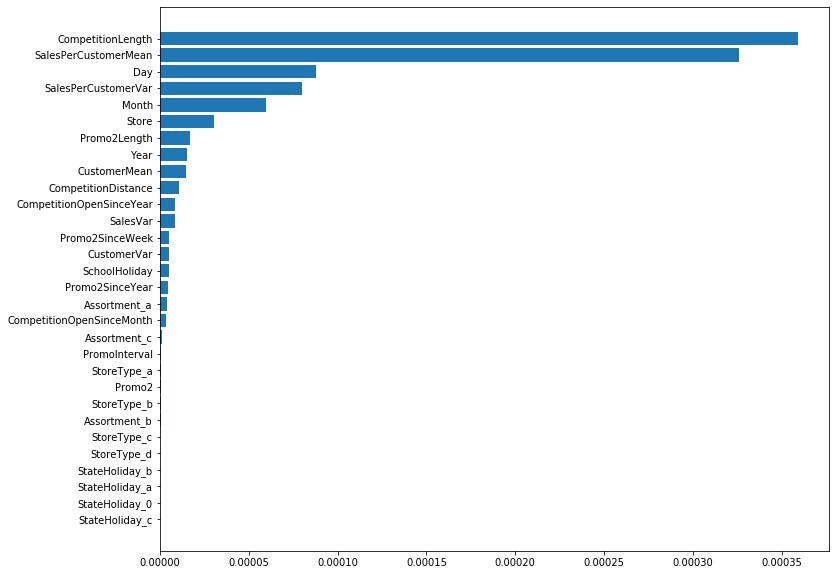

In [21]:
# WITH Customers AND SalesPerCustomer
X_train, X_test, y_train, y_test, cols = X_train1, X_test1, y_train1, y_test1, cols1
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
#predict
y_hat = decision_tree.predict(X_test)
get_scores(decision_tree, X_train, y_train, y_test, y_hat)
plot_importance(cols,decision_tree)

Root-Mean-Squared-Error: 0.1867631063358402
5-fold Cross Validation RMS Mean -0.24688175567340503
5-fold Cross Validation RMS Variance 0.012441796848772274


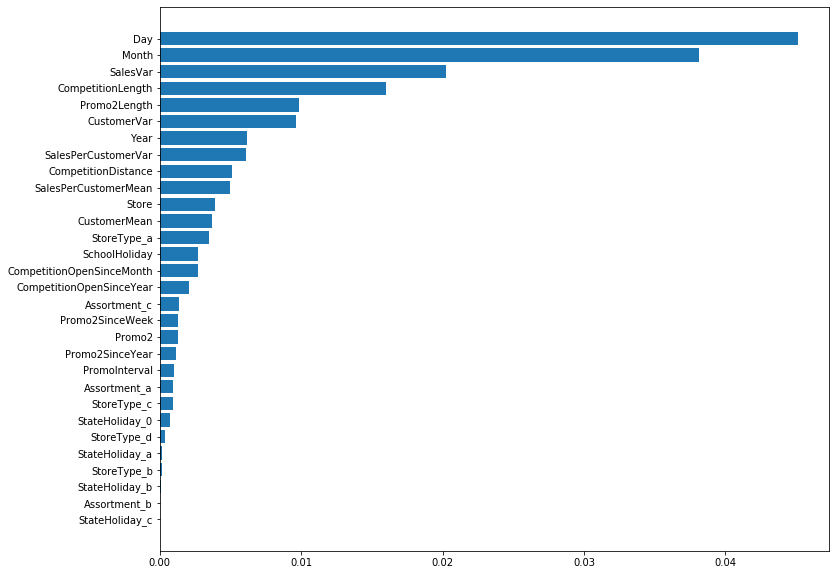

In [22]:
# WITHOUT Customers AND SalesPerCustomer
X_train, X_test, y_train, y_test, cols = X_train2, X_test2, y_train2, y_test2, cols2
# train
from sklearn.tree import DecisionTreeRegressor
decision_tree = DecisionTreeRegressor()
decision_tree.fit(X_train, y_train)
# test
y_hat = decision_tree.predict(X_test)
get_scores(decision_tree, X_train, y_train, y_test, y_hat)
plot_importance(cols,decision_tree)

## 2) Random Forest

In [17]:
plt.rcParams['figure.figsize'] = (12.0, 10.0)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   11.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   10.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    9.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 

Root-Mean-Squared-Error: 0.005965532853398424
5-fold Cross Validation RMS Mean -0.01018638891537193
5-fold Cross Validation RMS Variance 4.572098203916474e-05


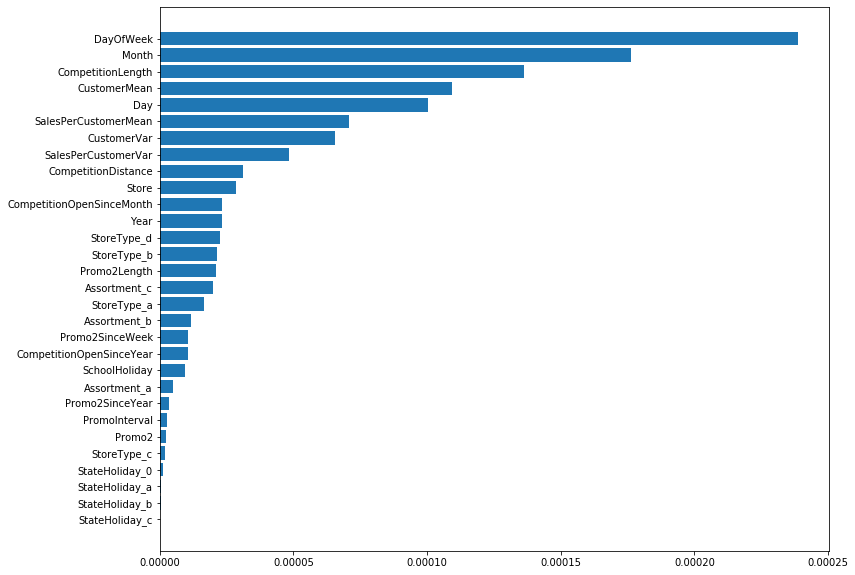

In [18]:
# WITH Customers AND SalesPerCustomer
X_train, X_test, y_train, y_test, cols = X_train1, X_test1, y_train1, y_test1, cols1
# train
from sklearn.ensemble import RandomForestRegressor
randomForest = RandomForestRegressor(n_estimators=25, n_jobs=-1, verbose=1)
randomForest.fit(X_train, y_train)
# test
y_hat = randomForest.predict(X_test)
get_scores(randomForest, X_train, y_train, y_test, y_hat)
plot_importance(cols,randomForest)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   10.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 

Root-Mean-Squared-Error: 0.1373614223761498
5-fold Cross Validation RMS Mean -0.20620424527715656
5-fold Cross Validation RMS Variance 0.015392684531219957


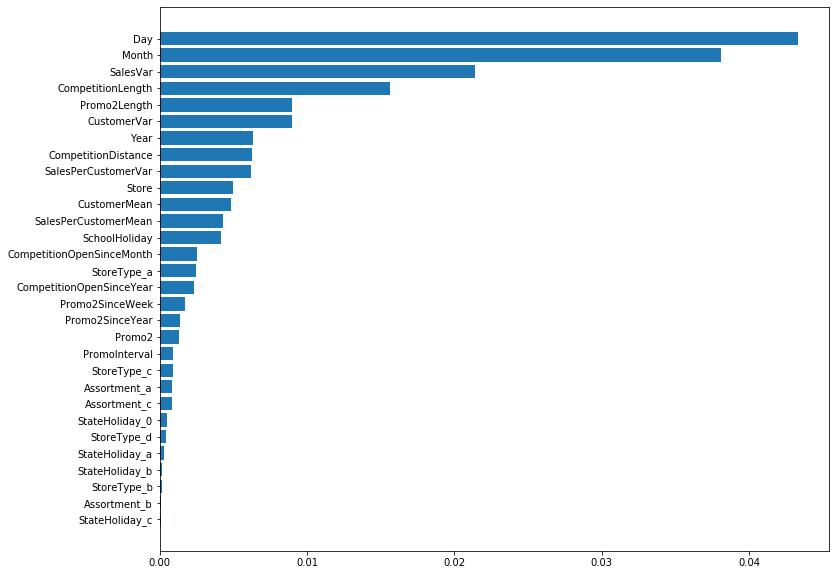

In [19]:
# WITHOUT Customers AND SalesPerCustomer
X_train, X_test, y_train, y_test, cols = X_train2, X_test2, y_train2, y_test2, cols2
# train
from sklearn.ensemble import RandomForestRegressor
randomForest = RandomForestRegressor(n_estimators=25, n_jobs=-1, verbose=1)
randomForest.fit(X_train, y_train)
# test
y_hat = randomForest.predict(X_test)
get_scores(randomForest, X_train, y_train, y_test, y_hat)
plot_importance(cols,randomForest)

## 3) Adaboost Trees

Root-Mean-Squared-Error: 0.006499591033924775
5-fold Cross Validation RMS Mean -0.009672629488667223
5-fold Cross Validation RMS Variance 4.044041973197938e-05


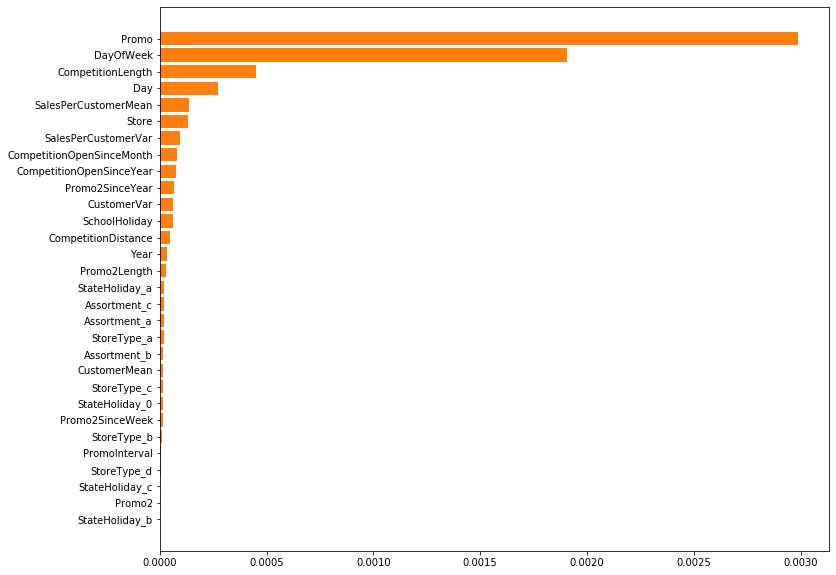

In [23]:
# WITH Customers AND SalesPerCustomer
X_train, X_test, y_train, y_test, cols = X_train1, X_test1, y_train1, y_test1, cols1
# train
from sklearn.ensemble import AdaBoostRegressor
adaboost_tree = AdaBoostRegressor(DecisionTreeRegressor())
adaboost_tree.fit(X_train, y_train)
plot_importance(cols,adaboost_tree)
# test
y_hat = adaboost_tree.predict(X_test)
get_scores(adaboost_tree, X_train, y_train, y_test, y_hat)
plot_importance(cols,adaboost_tree)

Root-Mean-Squared-Error: 0.1345394543948244
5-fold Cross Validation RMS Mean -0.2068258837330655
5-fold Cross Validation RMS Variance 0.015184979524195319


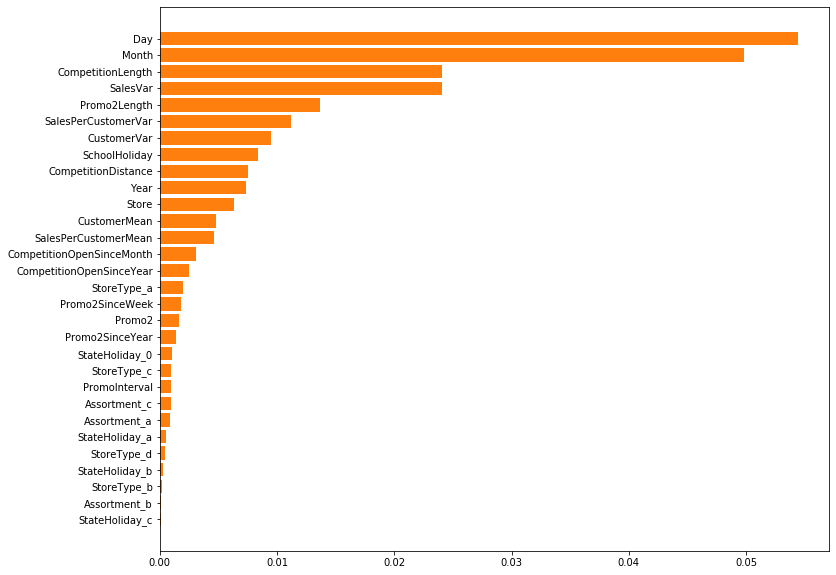

In [24]:
# WITHOUT Customers AND SalesPerCustomer
X_train, X_test, y_train, y_test, cols = X_train2, X_test2, y_train2, y_test2, cols2
# train
from sklearn.ensemble import AdaBoostRegressor
adaboost_tree = AdaBoostRegressor(DecisionTreeRegressor())
adaboost_tree.fit(X_train, y_train)
plot_importance(cols,adaboost_tree)
# test
y_hat = adaboost_tree.predict(X_test)
get_scores(adaboost_tree, X_train, y_train, y_test, y_hat)
plot_importance(cols,adaboost_tree)

## 4) XGB

In [25]:
# Define XGB specific functions
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

def rmspe_exp(y, y_hat):
    return rmspe(np.expm1(y), np.expm1(y_hat))

rmpse_xg_scorer = make_scorer(rmspe_exp, greater_is_better = False) # Loss function

def score(model, X_train, y_train, y_test, y_hat):
    score = cross_val_score(model, X_train, y_train, scoring=rmpse_xg_scorer, cv=5)
    print('Root-Mean-Squared-Error:', rmspe(y_test, np.expm1(y_hat)))
    print('5-fold Cross Validation RMS Mean', score.mean())
    print('5-fold Cross Validation RMS Variance', score.var())

In [26]:
# WITH Customers AND SalesPerCustomer
X_train, X_test, y_train, y_test, cols = X_train1, X_test1, y_train1, y_test1, cols1
# train
import xgboost as xgb
xgboost_tree = xgb.XGBRegressor(
    n_jobs = -1,
    n_estimators = 1000,
    eta = 0.1,
    max_depth = 2,
    min_child_weight = 2,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.05,
    silent = 0,
    random_state = 1023
)
xgboost_tree.fit(X_train[cols], np.log1p(y_train), 
                 eval_set = [(X_train[cols], np.log1p(y_train)), (X_test[cols], np.log1p(y_test))],
                 eval_metric = rmspe_xg,
                 early_stopping_rounds = 300
                )

//anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:08:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.44039	validation_1-rmse:7.44401	validation_0-rmspe:0.999529	validation_1-rmspe:0.99953
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 300 rounds.
[1]	validation_0-rmse:6.69726	validation_1-rmse:6.70039	validation_0-rmspe:0.998832	validation_1-rmspe:0.998834
[2]	validation_0-rmse:6.02853	validation_1-rmse:6.03123	validation_0-rmspe:0.997577	validation_1-rmspe:0.997579
[3]	validation_0-rmse:5.42676	validation_1-rmse:5.42907	validation_0-rmspe:0.995467	validation_1-rmspe:0.99547
[4]	validation_0-rmse:4.88518	validation_1-rmse:4.88738	validation_0-rmspe:0.992128	validation_1-rmspe:0.992133
[5]	validation_0-rmse:4.39811	validation_1-rmse:4.40015	validation_0-rmspe:0.98712	validation_1-rmspe:0.987126
[6]	validation_0-rmse:3.95945	validation_1-rmse:3.961

[70]	validation_0-rmse:0.063116	validation_1-rmse:0.065124	validation_0-rmspe:0.070083	validation_1-rmspe:0.066543
[71]	validation_0-rmse:0.062385	validation_1-rmse:0.064406	validation_0-rmspe:0.069412	validation_1-rmspe:0.065871
[72]	validation_0-rmse:0.06159	validation_1-rmse:0.063627	validation_0-rmspe:0.06877	validation_1-rmspe:0.065162
[73]	validation_0-rmse:0.060918	validation_1-rmse:0.06289	validation_0-rmspe:0.067911	validation_1-rmspe:0.06431
[74]	validation_0-rmse:0.060207	validation_1-rmse:0.062184	validation_0-rmspe:0.067095	validation_1-rmspe:0.063536
[75]	validation_0-rmse:0.059618	validation_1-rmse:0.061571	validation_0-rmspe:0.066525	validation_1-rmspe:0.062895
[76]	validation_0-rmse:0.058986	validation_1-rmse:0.060917	validation_0-rmspe:0.066055	validation_1-rmspe:0.062367
[77]	validation_0-rmse:0.05851	validation_1-rmse:0.060425	validation_0-rmspe:0.065584	validation_1-rmspe:0.061801
[78]	validation_0-rmse:0.057988	validation_1-rmse:0.059797	validation_0-rmspe:0.06433

[142]	validation_0-rmse:0.038838	validation_1-rmse:0.039845	validation_0-rmspe:0.042067	validation_1-rmspe:0.039823
[143]	validation_0-rmse:0.038706	validation_1-rmse:0.039707	validation_0-rmspe:0.041962	validation_1-rmspe:0.039704
[144]	validation_0-rmse:0.038495	validation_1-rmse:0.039498	validation_0-rmspe:0.04178	validation_1-rmspe:0.039511
[145]	validation_0-rmse:0.03829	validation_1-rmse:0.039283	validation_0-rmspe:0.041579	validation_1-rmspe:0.039294
[146]	validation_0-rmse:0.038092	validation_1-rmse:0.039088	validation_0-rmspe:0.041402	validation_1-rmspe:0.039102
[147]	validation_0-rmse:0.037967	validation_1-rmse:0.038976	validation_0-rmspe:0.041265	validation_1-rmspe:0.03897
[148]	validation_0-rmse:0.037744	validation_1-rmse:0.038757	validation_0-rmspe:0.04106	validation_1-rmspe:0.03876
[149]	validation_0-rmse:0.037566	validation_1-rmse:0.038579	validation_0-rmspe:0.040902	validation_1-rmspe:0.038582
[150]	validation_0-rmse:0.037426	validation_1-rmse:0.038418	validation_0-rmsp

[213]	validation_0-rmse:0.029484	validation_1-rmse:0.030141	validation_0-rmspe:0.030734	validation_1-rmspe:0.03009
[214]	validation_0-rmse:0.029369	validation_1-rmse:0.030027	validation_0-rmspe:0.030615	validation_1-rmspe:0.029971
[215]	validation_0-rmse:0.029296	validation_1-rmse:0.029954	validation_0-rmspe:0.030536	validation_1-rmspe:0.02989
[216]	validation_0-rmse:0.029166	validation_1-rmse:0.029824	validation_0-rmspe:0.030409	validation_1-rmspe:0.029763
[217]	validation_0-rmse:0.029045	validation_1-rmse:0.0297	validation_0-rmspe:0.030296	validation_1-rmspe:0.029643
[218]	validation_0-rmse:0.028918	validation_1-rmse:0.029566	validation_0-rmspe:0.030175	validation_1-rmspe:0.02951
[219]	validation_0-rmse:0.028836	validation_1-rmse:0.029479	validation_0-rmspe:0.030094	validation_1-rmspe:0.029424
[220]	validation_0-rmse:0.028771	validation_1-rmse:0.029412	validation_0-rmspe:0.030036	validation_1-rmspe:0.029363
[221]	validation_0-rmse:0.028657	validation_1-rmse:0.029299	validation_0-rmsp

[284]	validation_0-rmse:0.024021	validation_1-rmse:0.024591	validation_0-rmspe:0.024523	validation_1-rmspe:0.024581
[285]	validation_0-rmse:0.02395	validation_1-rmse:0.02452	validation_0-rmspe:0.024454	validation_1-rmspe:0.024512
[286]	validation_0-rmse:0.023906	validation_1-rmse:0.024475	validation_0-rmspe:0.024415	validation_1-rmspe:0.024469
[287]	validation_0-rmse:0.023868	validation_1-rmse:0.024437	validation_0-rmspe:0.024377	validation_1-rmspe:0.02443
[288]	validation_0-rmse:0.023793	validation_1-rmse:0.024357	validation_0-rmspe:0.024303	validation_1-rmspe:0.024351
[289]	validation_0-rmse:0.023716	validation_1-rmse:0.024278	validation_0-rmspe:0.024231	validation_1-rmspe:0.024276
[290]	validation_0-rmse:0.023665	validation_1-rmse:0.024224	validation_0-rmspe:0.024184	validation_1-rmspe:0.024227
[291]	validation_0-rmse:0.023582	validation_1-rmse:0.024134	validation_0-rmspe:0.024105	validation_1-rmspe:0.024138
[292]	validation_0-rmse:0.023533	validation_1-rmse:0.024078	validation_0-rm

[355]	validation_0-rmse:0.020621	validation_1-rmse:0.021166	validation_0-rmspe:0.020932	validation_1-rmspe:0.021171
[356]	validation_0-rmse:0.020586	validation_1-rmse:0.021129	validation_0-rmspe:0.020898	validation_1-rmspe:0.021135
[357]	validation_0-rmse:0.020553	validation_1-rmse:0.021101	validation_0-rmspe:0.020834	validation_1-rmspe:0.021104
[358]	validation_0-rmse:0.02052	validation_1-rmse:0.021065	validation_0-rmspe:0.020801	validation_1-rmspe:0.021069
[359]	validation_0-rmse:0.020489	validation_1-rmse:0.021034	validation_0-rmspe:0.020763	validation_1-rmspe:0.021033
[360]	validation_0-rmse:0.020461	validation_1-rmse:0.021005	validation_0-rmspe:0.020735	validation_1-rmspe:0.021003
[361]	validation_0-rmse:0.020415	validation_1-rmse:0.020958	validation_0-rmspe:0.020689	validation_1-rmspe:0.020956
[362]	validation_0-rmse:0.020392	validation_1-rmse:0.020936	validation_0-rmspe:0.020666	validation_1-rmspe:0.020934
[363]	validation_0-rmse:0.020349	validation_1-rmse:0.020891	validation_0-

[426]	validation_0-rmse:0.018498	validation_1-rmse:0.019095	validation_0-rmspe:0.018646	validation_1-rmspe:0.019042
[427]	validation_0-rmse:0.018468	validation_1-rmse:0.019064	validation_0-rmspe:0.018616	validation_1-rmspe:0.019011
[428]	validation_0-rmse:0.018445	validation_1-rmse:0.019047	validation_0-rmspe:0.018593	validation_1-rmspe:0.018993
[429]	validation_0-rmse:0.018423	validation_1-rmse:0.019053	validation_0-rmspe:0.018552	validation_1-rmspe:0.01899
[430]	validation_0-rmse:0.018403	validation_1-rmse:0.019031	validation_0-rmspe:0.018533	validation_1-rmspe:0.018968
[431]	validation_0-rmse:0.018373	validation_1-rmse:0.019	validation_0-rmspe:0.018503	validation_1-rmspe:0.018938
[432]	validation_0-rmse:0.01834	validation_1-rmse:0.01897	validation_0-rmspe:0.018471	validation_1-rmspe:0.018908
[433]	validation_0-rmse:0.018317	validation_1-rmse:0.018947	validation_0-rmspe:0.018447	validation_1-rmspe:0.018884
[434]	validation_0-rmse:0.018294	validation_1-rmse:0.018924	validation_0-rmspe

[497]	validation_0-rmse:0.016939	validation_1-rmse:0.017618	validation_0-rmspe:0.017037	validation_1-rmspe:0.017524
[498]	validation_0-rmse:0.016926	validation_1-rmse:0.017605	validation_0-rmspe:0.017024	validation_1-rmspe:0.01751
[499]	validation_0-rmse:0.016909	validation_1-rmse:0.017588	validation_0-rmspe:0.017008	validation_1-rmspe:0.017494
[500]	validation_0-rmse:0.016887	validation_1-rmse:0.017567	validation_0-rmspe:0.016986	validation_1-rmspe:0.017473
[501]	validation_0-rmse:0.016869	validation_1-rmse:0.017547	validation_0-rmspe:0.016968	validation_1-rmspe:0.017453
[502]	validation_0-rmse:0.016854	validation_1-rmse:0.017532	validation_0-rmspe:0.016952	validation_1-rmspe:0.017438
[503]	validation_0-rmse:0.016839	validation_1-rmse:0.017517	validation_0-rmspe:0.016938	validation_1-rmspe:0.017423
[504]	validation_0-rmse:0.016824	validation_1-rmse:0.017503	validation_0-rmspe:0.016922	validation_1-rmspe:0.017408
[505]	validation_0-rmse:0.01681	validation_1-rmse:0.017489	validation_0-r

[568]	validation_0-rmse:0.015786	validation_1-rmse:0.016564	validation_0-rmspe:0.01585	validation_1-rmspe:0.016429
[569]	validation_0-rmse:0.015772	validation_1-rmse:0.016547	validation_0-rmspe:0.015836	validation_1-rmspe:0.016413
[570]	validation_0-rmse:0.015757	validation_1-rmse:0.016531	validation_0-rmspe:0.015821	validation_1-rmspe:0.016397
[571]	validation_0-rmse:0.015748	validation_1-rmse:0.016522	validation_0-rmspe:0.015812	validation_1-rmspe:0.016388
[572]	validation_0-rmse:0.015737	validation_1-rmse:0.016511	validation_0-rmspe:0.015801	validation_1-rmspe:0.016377
[573]	validation_0-rmse:0.015723	validation_1-rmse:0.016499	validation_0-rmspe:0.015787	validation_1-rmspe:0.016364
[574]	validation_0-rmse:0.015707	validation_1-rmse:0.016484	validation_0-rmspe:0.015771	validation_1-rmspe:0.016349
[575]	validation_0-rmse:0.015694	validation_1-rmse:0.01647	validation_0-rmspe:0.015758	validation_1-rmspe:0.016335
[576]	validation_0-rmse:0.015681	validation_1-rmse:0.016458	validation_0-r

[639]	validation_0-rmse:0.0149	validation_1-rmse:0.015817	validation_0-rmspe:0.01493	validation_1-rmspe:0.015606
[640]	validation_0-rmse:0.01489	validation_1-rmse:0.015774	validation_0-rmspe:0.014922	validation_1-rmspe:0.015579
[641]	validation_0-rmse:0.014878	validation_1-rmse:0.015761	validation_0-rmspe:0.01491	validation_1-rmspe:0.015566
[642]	validation_0-rmse:0.014867	validation_1-rmse:0.015749	validation_0-rmspe:0.014899	validation_1-rmspe:0.015554
[643]	validation_0-rmse:0.014859	validation_1-rmse:0.015743	validation_0-rmspe:0.01489	validation_1-rmspe:0.015547
[644]	validation_0-rmse:0.014851	validation_1-rmse:0.015735	validation_0-rmspe:0.014882	validation_1-rmspe:0.015539
[645]	validation_0-rmse:0.014837	validation_1-rmse:0.015721	validation_0-rmspe:0.014868	validation_1-rmspe:0.015525
[646]	validation_0-rmse:0.014827	validation_1-rmse:0.015711	validation_0-rmspe:0.014858	validation_1-rmspe:0.015515
[647]	validation_0-rmse:0.014816	validation_1-rmse:0.015699	validation_0-rmspe

[710]	validation_0-rmse:0.01418	validation_1-rmse:0.015043	validation_0-rmspe:0.014209	validation_1-rmspe:0.014856
[711]	validation_0-rmse:0.014169	validation_1-rmse:0.015033	validation_0-rmspe:0.014198	validation_1-rmspe:0.014846
[712]	validation_0-rmse:0.01416	validation_1-rmse:0.015023	validation_0-rmspe:0.014189	validation_1-rmspe:0.014836
[713]	validation_0-rmse:0.014154	validation_1-rmse:0.015018	validation_0-rmspe:0.014183	validation_1-rmspe:0.014831
[714]	validation_0-rmse:0.014136	validation_1-rmse:0.015001	validation_0-rmspe:0.014165	validation_1-rmspe:0.014813
[715]	validation_0-rmse:0.014128	validation_1-rmse:0.014969	validation_0-rmspe:0.014158	validation_1-rmspe:0.014795
[716]	validation_0-rmse:0.014118	validation_1-rmse:0.014956	validation_0-rmspe:0.014148	validation_1-rmspe:0.014783
[717]	validation_0-rmse:0.01411	validation_1-rmse:0.014948	validation_0-rmspe:0.01414	validation_1-rmspe:0.014775
[718]	validation_0-rmse:0.014099	validation_1-rmse:0.014937	validation_0-rms

[781]	validation_0-rmse:0.013592	validation_1-rmse:0.014396	validation_0-rmspe:0.013615	validation_1-rmspe:0.014231
[782]	validation_0-rmse:0.013584	validation_1-rmse:0.014388	validation_0-rmspe:0.013607	validation_1-rmspe:0.014222
[783]	validation_0-rmse:0.01358	validation_1-rmse:0.014384	validation_0-rmspe:0.013603	validation_1-rmspe:0.014218
[784]	validation_0-rmse:0.013574	validation_1-rmse:0.014379	validation_0-rmspe:0.013597	validation_1-rmspe:0.014213
[785]	validation_0-rmse:0.013568	validation_1-rmse:0.014373	validation_0-rmspe:0.01359	validation_1-rmspe:0.014207
[786]	validation_0-rmse:0.013562	validation_1-rmse:0.014367	validation_0-rmspe:0.013584	validation_1-rmspe:0.014201
[787]	validation_0-rmse:0.013558	validation_1-rmse:0.014378	validation_0-rmspe:0.013578	validation_1-rmspe:0.014205
[788]	validation_0-rmse:0.013552	validation_1-rmse:0.014372	validation_0-rmspe:0.013571	validation_1-rmspe:0.014199
[789]	validation_0-rmse:0.01354	validation_1-rmse:0.014359	validation_0-rm

[852]	validation_0-rmse:0.013137	validation_1-rmse:0.013892	validation_0-rmspe:0.013158	validation_1-rmspe:0.013748
[853]	validation_0-rmse:0.013132	validation_1-rmse:0.013888	validation_0-rmspe:0.013154	validation_1-rmspe:0.013743
[854]	validation_0-rmse:0.013123	validation_1-rmse:0.013878	validation_0-rmspe:0.013144	validation_1-rmspe:0.013734
[855]	validation_0-rmse:0.013118	validation_1-rmse:0.013874	validation_0-rmspe:0.01314	validation_1-rmspe:0.01373
[856]	validation_0-rmse:0.013112	validation_1-rmse:0.013867	validation_0-rmspe:0.013133	validation_1-rmspe:0.013723
[857]	validation_0-rmse:0.013099	validation_1-rmse:0.013855	validation_0-rmspe:0.013121	validation_1-rmspe:0.01371
[858]	validation_0-rmse:0.013093	validation_1-rmse:0.013861	validation_0-rmspe:0.013114	validation_1-rmspe:0.013711
[859]	validation_0-rmse:0.013087	validation_1-rmse:0.013854	validation_0-rmspe:0.013107	validation_1-rmspe:0.013704
[860]	validation_0-rmse:0.013074	validation_1-rmse:0.013843	validation_0-rm

[923]	validation_0-rmse:0.012694	validation_1-rmse:0.013444	validation_0-rmspe:0.01271	validation_1-rmspe:0.013296
[924]	validation_0-rmse:0.012689	validation_1-rmse:0.01344	validation_0-rmspe:0.012706	validation_1-rmspe:0.013292
[925]	validation_0-rmse:0.012684	validation_1-rmse:0.013435	validation_0-rmspe:0.012701	validation_1-rmspe:0.013287
[926]	validation_0-rmse:0.012681	validation_1-rmse:0.013435	validation_0-rmspe:0.012698	validation_1-rmspe:0.013288
[927]	validation_0-rmse:0.012676	validation_1-rmse:0.013429	validation_0-rmspe:0.012693	validation_1-rmspe:0.013283
[928]	validation_0-rmse:0.012671	validation_1-rmse:0.013425	validation_0-rmspe:0.012687	validation_1-rmspe:0.013278
[929]	validation_0-rmse:0.012667	validation_1-rmse:0.013421	validation_0-rmspe:0.012684	validation_1-rmspe:0.013274
[930]	validation_0-rmse:0.012662	validation_1-rmse:0.013417	validation_0-rmspe:0.012679	validation_1-rmspe:0.01327
[931]	validation_0-rmse:0.012659	validation_1-rmse:0.013415	validation_0-rm

[994]	validation_0-rmse:0.012398	validation_1-rmse:0.013176	validation_0-rmspe:0.012408	validation_1-rmspe:0.01302
[995]	validation_0-rmse:0.012394	validation_1-rmse:0.013171	validation_0-rmspe:0.012403	validation_1-rmspe:0.013015
[996]	validation_0-rmse:0.012391	validation_1-rmse:0.013169	validation_0-rmspe:0.0124	validation_1-rmspe:0.013013
[997]	validation_0-rmse:0.012388	validation_1-rmse:0.013171	validation_0-rmspe:0.012396	validation_1-rmspe:0.013013
[998]	validation_0-rmse:0.012381	validation_1-rmse:0.013165	validation_0-rmspe:0.012389	validation_1-rmspe:0.013007
[999]	validation_0-rmse:0.012377	validation_1-rmse:0.01316	validation_0-rmspe:0.012385	validation_1-rmspe:0.013002


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=2, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=1023,
             reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=0, subsample=0.8, tree_method='exact', verbosity=1)

[22:12:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:14:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:16:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:18:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:20:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Root-Mean-Squared-Error: 0.013001859395610616
5-fold Cross Validation RMS Mean -0.015747667789616136
5-fold Cross Validation RMS Variance 3.477227341283043e-05


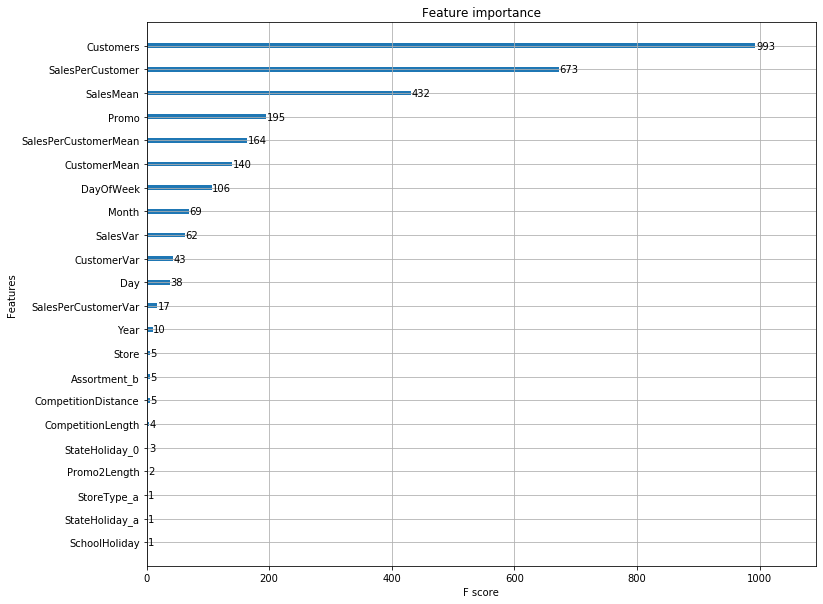

In [27]:
# test
y_hat = xgboost_tree.predict(X_test[cols])
score(xgboost_tree, X_train[cols], np.log1p(y_train), y_test, y_hat)
xgb.plot_importance(xgboost_tree)

In [28]:
# WITH Customers AND SalesPerCustomer
X_train, X_test, y_train, y_test, cols = X_train2, X_test2, y_train2, y_test2, cols2
# train
import xgboost as xgb
xgboost_tree = xgb.XGBRegressor(
    n_jobs = -1,
    n_estimators = 1000,
    eta = 0.1,
    max_depth = 2,
    min_child_weight = 2,
    subsample = 0.8,
    colsample_bytree = 0.8,
    tree_method = 'exact',
    reg_alpha = 0.05,
    silent = 0,
    random_state = 1023
)
xgboost_tree.fit(X_train[cols], np.log1p(y_train), 
                 eval_set = [(X_train[cols], np.log1p(y_train)), (X_test[cols], np.log1p(y_test))],
                 eval_metric = rmspe_xg,
                 early_stopping_rounds = 300
                )

[22:22:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.44091	validation_1-rmse:7.44482	validation_0-rmspe:0.999527	validation_1-rmspe:0.999528
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 300 rounds.
[1]	validation_0-rmse:6.69803	validation_1-rmse:6.70167	validation_0-rmspe:0.998825	validation_1-rmspe:0.998827
[2]	validation_0-rmse:6.02951	validation_1-rmse:6.03293	validation_0-rmspe:0.997561	validation_1-rmspe:0.997564
[3]	validation_0-rmse:5.42791	validation_1-rmse:5.43125	validation_0-rmspe:0.995432	validation_1-rmspe:0.995439
[4]	validation_0-rmse:4.88657	validation_1-rmse:4.88981	validation_0-rmspe:0.992064	validation_1-rmspe:0.992076
[5]	validation_0-rmse:4.39943	validation_1-rmse:4.40252	validation_0-rmspe:0.987032	validation_1-rmspe:0.98705
[6]	validation_0-rmse:3.96114	validation_1-rmse:3.9

[70]	validation_0-rmse:0.195067	validation_1-rmse:0.198423	validation_0-rmspe:0.296166	validation_1-rmspe:0.237038
[71]	validation_0-rmse:0.194739	validation_1-rmse:0.198118	validation_0-rmspe:0.296215	validation_1-rmspe:0.236884
[72]	validation_0-rmse:0.194506	validation_1-rmse:0.197865	validation_0-rmspe:0.296364	validation_1-rmspe:0.236672
[73]	validation_0-rmse:0.1943	validation_1-rmse:0.197676	validation_0-rmspe:0.296277	validation_1-rmspe:0.236638
[74]	validation_0-rmse:0.193846	validation_1-rmse:0.197223	validation_0-rmspe:0.296463	validation_1-rmspe:0.235953
[75]	validation_0-rmse:0.193643	validation_1-rmse:0.197024	validation_0-rmspe:0.296442	validation_1-rmspe:0.235674
[76]	validation_0-rmse:0.193456	validation_1-rmse:0.196839	validation_0-rmspe:0.296335	validation_1-rmspe:0.235583
[77]	validation_0-rmse:0.193265	validation_1-rmse:0.196613	validation_0-rmspe:0.296179	validation_1-rmspe:0.235232
[78]	validation_0-rmse:0.193068	validation_1-rmse:0.19642	validation_0-rmspe:0.296

[142]	validation_0-rmse:0.1815	validation_1-rmse:0.18466	validation_0-rmspe:0.285149	validation_1-rmspe:0.217107
[143]	validation_0-rmse:0.18144	validation_1-rmse:0.1846	validation_0-rmspe:0.285068	validation_1-rmspe:0.217015
[144]	validation_0-rmse:0.180764	validation_1-rmse:0.183871	validation_0-rmspe:0.284081	validation_1-rmspe:0.215835
[145]	validation_0-rmse:0.180707	validation_1-rmse:0.183804	validation_0-rmspe:0.284005	validation_1-rmspe:0.215732
[146]	validation_0-rmse:0.180642	validation_1-rmse:0.18375	validation_0-rmspe:0.283947	validation_1-rmspe:0.215673
[147]	validation_0-rmse:0.180584	validation_1-rmse:0.183678	validation_0-rmspe:0.284103	validation_1-rmspe:0.215394
[148]	validation_0-rmse:0.180476	validation_1-rmse:0.183579	validation_0-rmspe:0.284182	validation_1-rmspe:0.215306
[149]	validation_0-rmse:0.180078	validation_1-rmse:0.183207	validation_0-rmspe:0.28396	validation_1-rmspe:0.214869
[150]	validation_0-rmse:0.180026	validation_1-rmse:0.183154	validation_0-rmspe:0

[214]	validation_0-rmse:0.173812	validation_1-rmse:0.17697	validation_0-rmspe:0.278157	validation_1-rmspe:0.203674
[215]	validation_0-rmse:0.173765	validation_1-rmse:0.176908	validation_0-rmspe:0.278057	validation_1-rmspe:0.203591
[216]	validation_0-rmse:0.173737	validation_1-rmse:0.176886	validation_0-rmspe:0.278084	validation_1-rmspe:0.203536
[217]	validation_0-rmse:0.173598	validation_1-rmse:0.176756	validation_0-rmspe:0.278121	validation_1-rmspe:0.203465
[218]	validation_0-rmse:0.173555	validation_1-rmse:0.176716	validation_0-rmspe:0.278038	validation_1-rmspe:0.203238
[219]	validation_0-rmse:0.173514	validation_1-rmse:0.176663	validation_0-rmspe:0.277992	validation_1-rmspe:0.203199
[220]	validation_0-rmse:0.173156	validation_1-rmse:0.176278	validation_0-rmspe:0.277522	validation_1-rmspe:0.202579
[221]	validation_0-rmse:0.17273	validation_1-rmse:0.175857	validation_0-rmspe:0.277246	validation_1-rmspe:0.201879
[222]	validation_0-rmse:0.172673	validation_1-rmse:0.175801	validation_0-r

[285]	validation_0-rmse:0.169707	validation_1-rmse:0.172801	validation_0-rmspe:0.274705	validation_1-rmspe:0.196753
[286]	validation_0-rmse:0.169691	validation_1-rmse:0.172786	validation_0-rmspe:0.274683	validation_1-rmspe:0.196693
[287]	validation_0-rmse:0.169676	validation_1-rmse:0.172774	validation_0-rmspe:0.27464	validation_1-rmspe:0.196671
[288]	validation_0-rmse:0.169666	validation_1-rmse:0.172766	validation_0-rmspe:0.274622	validation_1-rmspe:0.196675
[289]	validation_0-rmse:0.169639	validation_1-rmse:0.172742	validation_0-rmspe:0.27457	validation_1-rmspe:0.196632
[290]	validation_0-rmse:0.169616	validation_1-rmse:0.172714	validation_0-rmspe:0.274602	validation_1-rmspe:0.196573
[291]	validation_0-rmse:0.16959	validation_1-rmse:0.172683	validation_0-rmspe:0.274535	validation_1-rmspe:0.196521
[292]	validation_0-rmse:0.169583	validation_1-rmse:0.172673	validation_0-rmspe:0.274533	validation_1-rmspe:0.196507
[293]	validation_0-rmse:0.169557	validation_1-rmse:0.172653	validation_0-rm

[356]	validation_0-rmse:0.167029	validation_1-rmse:0.170163	validation_0-rmspe:0.271922	validation_1-rmspe:0.1916
[357]	validation_0-rmse:0.16695	validation_1-rmse:0.170073	validation_0-rmspe:0.2719	validation_1-rmspe:0.19147
[358]	validation_0-rmse:0.16693	validation_1-rmse:0.170049	validation_0-rmspe:0.271897	validation_1-rmspe:0.191506
[359]	validation_0-rmse:0.166918	validation_1-rmse:0.170043	validation_0-rmspe:0.271906	validation_1-rmspe:0.19151
[360]	validation_0-rmse:0.16691	validation_1-rmse:0.170042	validation_0-rmspe:0.271903	validation_1-rmspe:0.191516
[361]	validation_0-rmse:0.16687	validation_1-rmse:0.169996	validation_0-rmspe:0.271975	validation_1-rmspe:0.191492
[362]	validation_0-rmse:0.16686	validation_1-rmse:0.169983	validation_0-rmspe:0.27194	validation_1-rmspe:0.191476
[363]	validation_0-rmse:0.166705	validation_1-rmse:0.169821	validation_0-rmspe:0.27181	validation_1-rmspe:0.191151
[364]	validation_0-rmse:0.16669	validation_1-rmse:0.16981	validation_0-rmspe:0.271806

[428]	validation_0-rmse:0.164678	validation_1-rmse:0.167868	validation_0-rmspe:0.269759	validation_1-rmspe:0.187936
[429]	validation_0-rmse:0.164667	validation_1-rmse:0.167856	validation_0-rmspe:0.269736	validation_1-rmspe:0.18794
[430]	validation_0-rmse:0.164653	validation_1-rmse:0.167849	validation_0-rmspe:0.269727	validation_1-rmspe:0.187935
[431]	validation_0-rmse:0.164619	validation_1-rmse:0.167828	validation_0-rmspe:0.269678	validation_1-rmspe:0.187926
[432]	validation_0-rmse:0.164593	validation_1-rmse:0.167805	validation_0-rmspe:0.269577	validation_1-rmspe:0.187907
[433]	validation_0-rmse:0.164576	validation_1-rmse:0.16779	validation_0-rmspe:0.269571	validation_1-rmspe:0.187914
[434]	validation_0-rmse:0.16457	validation_1-rmse:0.167786	validation_0-rmspe:0.269568	validation_1-rmspe:0.187917
[435]	validation_0-rmse:0.164565	validation_1-rmse:0.167782	validation_0-rmspe:0.269553	validation_1-rmspe:0.187904
[436]	validation_0-rmse:0.164484	validation_1-rmse:0.167697	validation_0-rm

[499]	validation_0-rmse:0.162223	validation_1-rmse:0.165277	validation_0-rmspe:0.267048	validation_1-rmspe:0.183657
[500]	validation_0-rmse:0.162218	validation_1-rmse:0.165274	validation_0-rmspe:0.267045	validation_1-rmspe:0.183655
[501]	validation_0-rmse:0.162213	validation_1-rmse:0.165271	validation_0-rmspe:0.26704	validation_1-rmspe:0.183637
[502]	validation_0-rmse:0.162205	validation_1-rmse:0.165267	validation_0-rmspe:0.267035	validation_1-rmspe:0.183633
[503]	validation_0-rmse:0.162202	validation_1-rmse:0.165263	validation_0-rmspe:0.267045	validation_1-rmspe:0.183639
[504]	validation_0-rmse:0.162177	validation_1-rmse:0.165235	validation_0-rmspe:0.266991	validation_1-rmspe:0.183618
[505]	validation_0-rmse:0.162169	validation_1-rmse:0.165232	validation_0-rmspe:0.267013	validation_1-rmspe:0.183629
[506]	validation_0-rmse:0.162162	validation_1-rmse:0.165225	validation_0-rmspe:0.267012	validation_1-rmspe:0.18363
[507]	validation_0-rmse:0.162158	validation_1-rmse:0.165222	validation_0-r

[570]	validation_0-rmse:0.160085	validation_1-rmse:0.162944	validation_0-rmspe:0.264703	validation_1-rmspe:0.179261
[571]	validation_0-rmse:0.160055	validation_1-rmse:0.162918	validation_0-rmspe:0.264734	validation_1-rmspe:0.179207
[572]	validation_0-rmse:0.16005	validation_1-rmse:0.162916	validation_0-rmspe:0.264712	validation_1-rmspe:0.179204
[573]	validation_0-rmse:0.16004	validation_1-rmse:0.162916	validation_0-rmspe:0.264709	validation_1-rmspe:0.179201
[574]	validation_0-rmse:0.159997	validation_1-rmse:0.162871	validation_0-rmspe:0.264708	validation_1-rmspe:0.179185
[575]	validation_0-rmse:0.15999	validation_1-rmse:0.162868	validation_0-rmspe:0.264695	validation_1-rmspe:0.179178
[576]	validation_0-rmse:0.159984	validation_1-rmse:0.162863	validation_0-rmspe:0.264687	validation_1-rmspe:0.17918
[577]	validation_0-rmse:0.159979	validation_1-rmse:0.162863	validation_0-rmspe:0.264683	validation_1-rmspe:0.179173
[578]	validation_0-rmse:0.159958	validation_1-rmse:0.162843	validation_0-rms

[641]	validation_0-rmse:0.158703	validation_1-rmse:0.161623	validation_0-rmspe:0.263988	validation_1-rmspe:0.177433
[642]	validation_0-rmse:0.158691	validation_1-rmse:0.161611	validation_0-rmspe:0.263961	validation_1-rmspe:0.177415
[643]	validation_0-rmse:0.158689	validation_1-rmse:0.161607	validation_0-rmspe:0.263985	validation_1-rmspe:0.177418
[644]	validation_0-rmse:0.158644	validation_1-rmse:0.161559	validation_0-rmspe:0.263924	validation_1-rmspe:0.177341
[645]	validation_0-rmse:0.158637	validation_1-rmse:0.161557	validation_0-rmspe:0.263921	validation_1-rmspe:0.177335
[646]	validation_0-rmse:0.158589	validation_1-rmse:0.161502	validation_0-rmspe:0.263745	validation_1-rmspe:0.177286
[647]	validation_0-rmse:0.158564	validation_1-rmse:0.161477	validation_0-rmspe:0.263702	validation_1-rmspe:0.177255
[648]	validation_0-rmse:0.158562	validation_1-rmse:0.161473	validation_0-rmspe:0.263721	validation_1-rmspe:0.177254
[649]	validation_0-rmse:0.158541	validation_1-rmse:0.161447	validation_0

[712]	validation_0-rmse:0.157426	validation_1-rmse:0.160289	validation_0-rmspe:0.26249	validation_1-rmspe:0.175392
[713]	validation_0-rmse:0.157357	validation_1-rmse:0.160221	validation_0-rmspe:0.26247	validation_1-rmspe:0.175266
[714]	validation_0-rmse:0.157345	validation_1-rmse:0.160207	validation_0-rmspe:0.26244	validation_1-rmspe:0.175242
[715]	validation_0-rmse:0.157339	validation_1-rmse:0.160201	validation_0-rmspe:0.262425	validation_1-rmspe:0.175233
[716]	validation_0-rmse:0.157327	validation_1-rmse:0.160189	validation_0-rmspe:0.262396	validation_1-rmspe:0.175224
[717]	validation_0-rmse:0.157324	validation_1-rmse:0.160189	validation_0-rmspe:0.262384	validation_1-rmspe:0.175223
[718]	validation_0-rmse:0.15731	validation_1-rmse:0.160171	validation_0-rmspe:0.262374	validation_1-rmspe:0.175124
[719]	validation_0-rmse:0.157299	validation_1-rmse:0.160161	validation_0-rmspe:0.262365	validation_1-rmspe:0.175077
[720]	validation_0-rmse:0.157294	validation_1-rmse:0.160161	validation_0-rms

[783]	validation_0-rmse:0.156294	validation_1-rmse:0.159144	validation_0-rmspe:0.261954	validation_1-rmspe:0.173529
[784]	validation_0-rmse:0.156292	validation_1-rmse:0.159144	validation_0-rmspe:0.261963	validation_1-rmspe:0.173545
[785]	validation_0-rmse:0.156286	validation_1-rmse:0.159137	validation_0-rmspe:0.261972	validation_1-rmspe:0.173553
[786]	validation_0-rmse:0.156278	validation_1-rmse:0.159137	validation_0-rmspe:0.261941	validation_1-rmspe:0.173507
[787]	validation_0-rmse:0.156258	validation_1-rmse:0.159115	validation_0-rmspe:0.261918	validation_1-rmspe:0.173484
[788]	validation_0-rmse:0.156253	validation_1-rmse:0.159108	validation_0-rmspe:0.261921	validation_1-rmspe:0.173504
[789]	validation_0-rmse:0.156236	validation_1-rmse:0.159092	validation_0-rmspe:0.261876	validation_1-rmspe:0.173483
[790]	validation_0-rmse:0.156196	validation_1-rmse:0.159036	validation_0-rmspe:0.261822	validation_1-rmspe:0.173394
[791]	validation_0-rmse:0.156185	validation_1-rmse:0.159024	validation_0

[854]	validation_0-rmse:0.155495	validation_1-rmse:0.158395	validation_0-rmspe:0.261261	validation_1-rmspe:0.172478
[855]	validation_0-rmse:0.155492	validation_1-rmse:0.158391	validation_0-rmspe:0.261267	validation_1-rmspe:0.172478
[856]	validation_0-rmse:0.155457	validation_1-rmse:0.15834	validation_0-rmspe:0.261243	validation_1-rmspe:0.172416
[857]	validation_0-rmse:0.155455	validation_1-rmse:0.158337	validation_0-rmspe:0.261237	validation_1-rmspe:0.172409
[858]	validation_0-rmse:0.155408	validation_1-rmse:0.158289	validation_0-rmspe:0.261211	validation_1-rmspe:0.172323
[859]	validation_0-rmse:0.155403	validation_1-rmse:0.158286	validation_0-rmspe:0.261201	validation_1-rmspe:0.17233
[860]	validation_0-rmse:0.155392	validation_1-rmse:0.158269	validation_0-rmspe:0.261193	validation_1-rmspe:0.172198
[861]	validation_0-rmse:0.155389	validation_1-rmse:0.158261	validation_0-rmspe:0.261149	validation_1-rmspe:0.172181
[862]	validation_0-rmse:0.155383	validation_1-rmse:0.158258	validation_0-r

[925]	validation_0-rmse:0.154736	validation_1-rmse:0.15766	validation_0-rmspe:0.260735	validation_1-rmspe:0.171328
[926]	validation_0-rmse:0.154724	validation_1-rmse:0.157645	validation_0-rmspe:0.260706	validation_1-rmspe:0.17132
[927]	validation_0-rmse:0.154723	validation_1-rmse:0.157647	validation_0-rmspe:0.260707	validation_1-rmspe:0.171324
[928]	validation_0-rmse:0.154717	validation_1-rmse:0.157642	validation_0-rmspe:0.260714	validation_1-rmspe:0.171321
[929]	validation_0-rmse:0.154711	validation_1-rmse:0.157632	validation_0-rmspe:0.2607	validation_1-rmspe:0.171291
[930]	validation_0-rmse:0.154709	validation_1-rmse:0.157633	validation_0-rmspe:0.260704	validation_1-rmspe:0.171289
[931]	validation_0-rmse:0.154701	validation_1-rmse:0.157623	validation_0-rmspe:0.260694	validation_1-rmspe:0.171236
[932]	validation_0-rmse:0.154689	validation_1-rmse:0.157612	validation_0-rmspe:0.260672	validation_1-rmspe:0.171156
[933]	validation_0-rmse:0.154682	validation_1-rmse:0.157606	validation_0-rms

[996]	validation_0-rmse:0.153902	validation_1-rmse:0.156799	validation_0-rmspe:0.260477	validation_1-rmspe:0.169937
[997]	validation_0-rmse:0.153896	validation_1-rmse:0.156799	validation_0-rmspe:0.260471	validation_1-rmspe:0.169928
[998]	validation_0-rmse:0.153887	validation_1-rmse:0.156788	validation_0-rmspe:0.260363	validation_1-rmspe:0.169893
[999]	validation_0-rmse:0.153878	validation_1-rmse:0.156779	validation_0-rmspe:0.260434	validation_1-rmspe:0.169878


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=2, min_child_weight=2, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=1023,
             reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=0, subsample=0.8, tree_method='exact', verbosity=1)

[22:30:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:32:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:33:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:35:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:37:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Root-Mean-Squared-Error: 0.16987843890074195
5-fold Cross Validation RMS Mean -0.23157611940952183
5-fold Cross Validation RMS Variance 0.015111975527264957


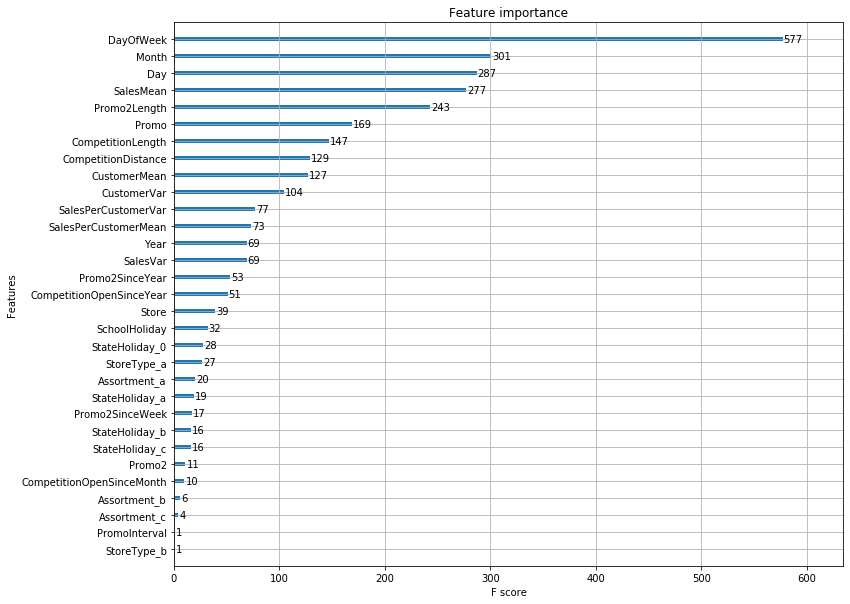

In [29]:
# test
y_hat = xgboost_tree.predict(X_test[cols])
score(xgboost_tree, X_train[cols], np.log1p(y_train), y_test, y_hat)
xgb.plot_importance(xgboost_tree)

# 5. Final Model and Performances

In [32]:
import json
df = pd.read_csv('data/new_train.csv', index_col=0)
df['PromoInterval']= df['PromoInterval'].apply(lambda x: json.loads(x))
df = feature_encoding(df)
df = df[df.Sales>0]

# WITHOUT Columns Customers or SalesPerCustomer
df = df.drop('Customers',1).drop('SalesPerCustomer',1)
cols = df.drop('Sales',1).columns

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Sales',1), df['Sales'], test_size=0.15, random_state=10)

Encoded ['StoreType', 'Assortment', 'StateHoliday'] successfully.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   43.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   38.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   35.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 

Root-Mean-Squared-Error: 0.12396304520411233
5-fold Cross Validation RMS Mean -0.18883973787725777
5-fold Cross Validation RMS Variance 0.004468178587077225


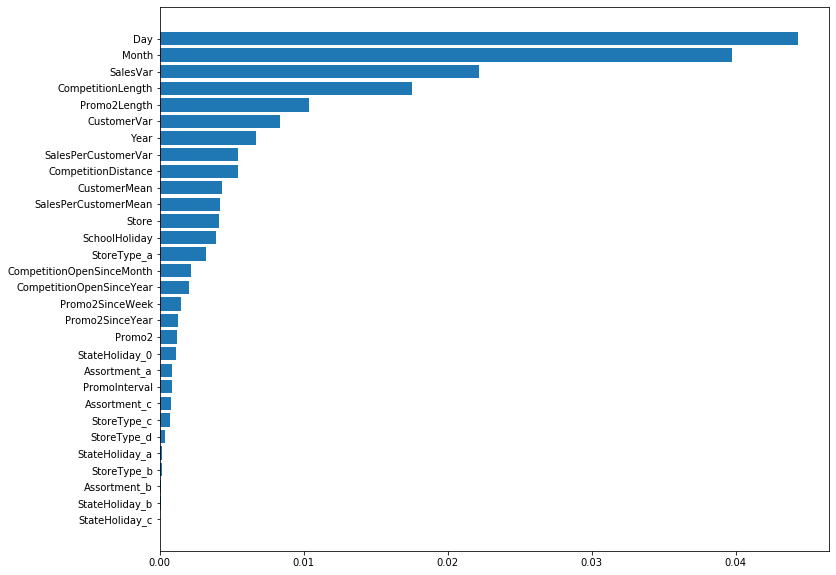

In [45]:
# train
from sklearn.ensemble import RandomForestRegressor
randomForest = RandomForestRegressor(n_estimators=25, n_jobs=-1, verbose=1)
randomForest.fit(X_train, y_train)
# test
y_hat = randomForest.predict(X_test)
get_scores(randomForest, X_train, y_train, y_test, y_hat)
plot_importance(cols,randomForest)

In [50]:
import pickle
# save the model to disk
filename = 'final_rf_model.sav'
pickle.dump(randomForest, open('data/'+filename, 'wb'))

# 6. Submission

In [35]:
# combine with store data to get feature table
dp1 = get_features(ds1, dp)
# feature encoding: might miss certain categories if does not include all categories, find the columns and add them back
dp2 = feature_encoding(dp1)
missing_cols = set(X_train.columns) - set(dp2.columns)
for col in missing_cols:
    dp2[col] = 0


Encoded ['StoreType', 'Assortment', 'StateHoliday'] successfully.


In [46]:
# predict
model = randomForest
# y_hat = xgboost_tree.predict(dp2[cols])
y_hat = model.predict(dp2)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:    0.1s finished


In [47]:
submission = pd.DataFrame(index=dp.index)
dp_f = pd.DataFrame({"Id": dp2.index, 'Sales': y_hat})
submission['Sales'] = dp_f['Sales']
submission = submission.fillna(0).astype(int)
submission.to_csv('data/submission_guo.csv')

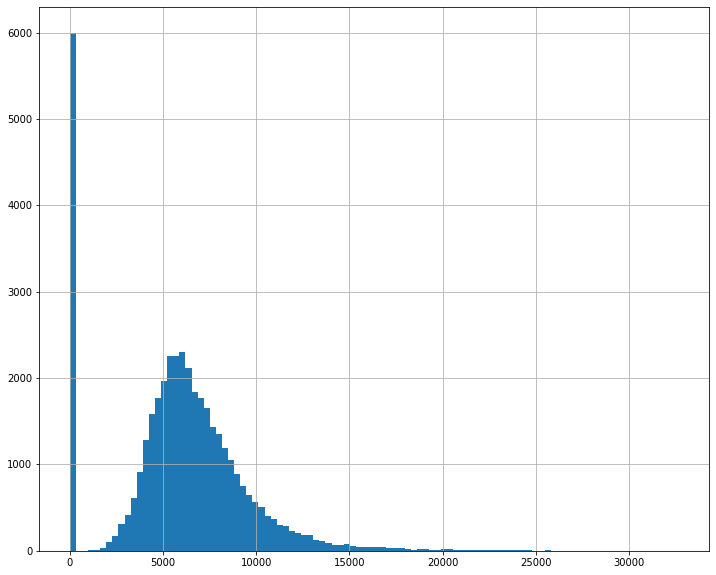

In [48]:
submission.Sales.hist(bins=100)

In [52]:
submission.head(10)

,Sales
Id,
1,7530
2,9038
3,7552
4,6489
5,5720
6,7884
7,8027
8,7977
9,5690
